# *An Evaluation of Convolutional Neural Network Architecture Efficacy on the LUCAS Soil Spectra Dataset*
*Coursework 2*
**Subject:** *DSM-150 Neural Networks*

**By:** *Vincent van der Berg*
**Student Number:** *200510725*

## *Abstract*

This workbook evaluated numerous sequential neural network architectures' predictive potential on the largest spectroscopic dataset for Europe.  Organic carbon was selected as the target variable for this regression task.  Different optimisers were evaluated alongside the different architectures to identify an ideal hyperparameter configuration.  Finally, the effect of regularisation on a models ability to overfit was also evaluated.  The final model was able to predict organic carbon with a greater accuracy that established methods that were used as the baseline in this project.  Besides improvement in accuracy, a sequential neural network appears to not be the optimal architecture for this modelling task.

Table of Contents
 - [Introduction](#introduction)
 - [General workflow](#gen_wf)
    - [1) Problem definition and dataset assembly](#firstsection)
    - [2) Defining measure of success](#secondsection)
    - [3) Evaluation protocol](#thirdsection)
    - [4) Model architecture engineering](#fifthsection)
        - [a) DenseSpectraNet](#densespectranet)
        - [b) VGGSpectraNet](#vggspectranet)
        - [c) ReSpectraNet](#respectranet)
    - [5) Model selection](#sixthsection)
 - [Final model evlauation](#finalmodel)
 - [Conclusion](#conclusion)
 - [References](#references)

### Required Packages

In [1]:
## Import general packages
import random

## Import packages for data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## Import packages for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras

## Import packages for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Flatten, Dense,
                                     BatchNormalization, Activation, Concatenate,
                                     GlobalAveragePooling1D, GlobalMaxPooling1D)

## Set global figure size
plt.rcParams['figure.figsize'] = [10, 8]

## Set seed
random.seed(42)

## *Introduction* <a id="introduction"></a>


Soil serves as a major production source of staple foods and fibres that sustain our modern global populations.  It is a vital component of the Earth’s critical zone, existing as a heterogenous matrix composed of solid, liquid and air.  To manage the sustainable use of soils efficiently for food and fibre production, it is imperative that we develop the most comprehensive understanding possible of the nature, properties, and interactions of our soils (Viscarra Rossel & McBratney, 1998).  The health and production potential of a soil is closely related to the presence of essential components such as carbon, nitrogen, and potassium, which play a crucial role in maintaining the fertility and productivity of soils.  Additionally, soil pH is a significant determining factor to nutrient availability in soils.  It is therefore essential for sustainable agriculture and efficient land management to estimate soil pH and carbon, nitrogen, and potassium contents in soils.

A soil system’s physical and chemical characterisation is traditionally determined by the wet chemistry analysis of soil samples (van Leeuwen, et al., 2022).  These conventional analysis techniques are time-consuming, costly, and environmentally unfriendly (Viscarra Rossel & McBratney, 1998).  Spectroscopic analysis has become a popular alternative method for determining soil properties due to its rapid and non-destructive ability to provide soil information (Nocita, et al., 2015).  As such, spectroscopy has become a more widely used method for determining soil properties.  Yet soil spectroscopy datasets typically contain a large number of features (i.e. wavelengths) and a comparatively small number of samples.  This has traditionally made it a challenging problem to predict soil properties accurately from such datasets.

Convolutional neural networks (CCNs) have gained significant attention in recent years due to their excellent performance with image and signal processing tasks.  Several studies have evaluated the potential of CNNs in predicting soil properties from spectroscopy data.  Bao, et al. (2020) evaluated a CNN architecture on its ability to predict soil carbon and total nitrogen content from visible and near infrared (VIS-NIR) spectral data.  The authors concluded that their CNN model outperformed other traditional machine learning algorithms, including random forests and support vector regression techniques.  Zhang, et al. (2020) similarly proposed a CNN model for the prediction of soil carbon content from VIS-NIR spectral data.  The authors came to a similar conclusion to Bao, et al. (2020), in that their model achieved significantly higher accuracy compared to other machine learning techniques.

Considering the examples mentioned above, in addition to numerous other similar studies, few studies have evaluated the performance of multiple CNN architectures on their ability to predict multiple soil properties simultaneously.  The aim of this study is to fill this apparent gap by evaluating three novel CNN architectures, two of which are based on the VGG and ResNet model architectures.  The other model relied on a few CNN layers as a simultaneous feature extraction and dimensionality reduction technique, of which the outputs were fed to fully connected neural layers.  In this study, these three architectures are evaluated on their modelling potential on the LUCAS soil spectroscopy dataset to predict soil pH, and carbon, nitrogen, and potassium contents.

## *General Workflow* <a id="gen_wf"></a>

### 1) Problem definition and dataset assembly <a id="firstsection"></a>

This notebook addresses the prediction of soil pH and carbon, nitrogen, and potassium contents based on spectroscopy data as input to the models.  These soil properties are essential indicators of soil fertility, and their accurate estimation can aid in crop management, soil conservation, and environmental modelling.

The LUCAS soil spectroscopy dataset that was used in this study, is a publicly available dataset that includes soil chemical and spectral data that was collected from more than 20 000 soil samples across 28 European Union member states.  The spectral data were obtained using diffuse reflective spectroscopy with a visible near-infrared (VIS-NIR) spectrophotometer.  Diffuse reflective spectroscopy involves shining visible and infrared light on a soil surface and measuring the reflected light at various wavelengths.  The VIS-NIR spectrophotometer measured reflectance in the wavelength range of 400 to 2498 nm.

The dataset was imported below from a .csv-file, after which a few simple manipulations were performed.  Soil textural (e.g. sand, silt, clay) data were removed, as it was not a variable of interest in this study.  Spectroscopic measurements were made in duplicate, thus soil samples were grouped by their respective sample codes and country identifiers.  The mean spectra for each sample was determined from the grouped soil samples.  The violet and blue wavelengths (400 - 500 nm) were removed, as these wavelengths were particularly noisy.  The dataset underwent quality assurance prior to download, and thus does not contain any missing values.

In [2]:
## Import raw dataset
data = pd.read_csv(filepath_or_buffer="./data/LUCAS_data_complete.csv")
spectral_df = data.copy()

## Manipulate data
spectral_df.drop(['Coarse', 'Clay', 'Sand', 'Silt'], inplace=True, axis=1) # Drop soil texture columns
spectral_df.drop(spectral_df.iloc[:, 2:102], inplace=True, axis=1) # Remove violet and blue wavelengths
spectral_data = spectral_df.groupby(['PointID', 'NUTS_0']).mean() # Take mean sample means
spectral_data.head(5) # Display first 5 entries

,,500,501,502,503,504,505,506,507,508,509,...,2498,2499,pH_CaCl,pH_H2O,EC,OC,CaCO3,P,N,K
PointID,NUTS_0,,,,,,,,,,,,,,,,,,,,,
26581768,PT,0.932929,0.930973,0.928993,0.926990,0.924966,0.922920,0.920855,0.918784,0.916697,0.914589,...,0.466295,0.466311,6.9,7.24,18.14,24.6,34.0,24.3,2.9,245.6
26581792,PT,0.766713,0.764566,0.762376,0.760147,0.757874,0.755559,0.753207,0.750816,0.748386,0.745932,...,0.324370,0.324254,5.4,5.81,14.81,21.9,0.0,3.4,2.3,150.0
26581954,PT,0.952716,0.950813,0.948872,0.946910,0.944931,0.942930,0.940913,0.938894,0.936870,0.934831,...,0.572002,0.572313,7.0,7.29,28.10,18.4,46.0,56.5,2.1,505.2
26601784,PT,0.959969,0.958155,0.956303,0.954430,0.952536,0.950622,0.948690,0.946755,0.944818,0.942867,...,0.357277,0.357246,4.4,5.17,5.37,48.0,0.0,5.6,3.3,103.8
26601978,PT,0.952042,0.950492,0.948906,0.947304,0.945680,0.944036,0.942373,0.940705,0.939028,0.937332,...,0.469747,0.469812,7.1,7.38,21.60,25.2,0.0,7.2,2.1,174.6


To prepare the dataset for modelling, it underwent a few transformations to make it suitable for deep learning.  First, the feature dataset underwent min-max normalisation to scale the values between 0 and 1.  Rescaling values to lie within this range generally helps to facilitate learning and allows the model to converge faster.  Considering that outlier data might be prevalent in the LUCAS dataset, normalisation may also have helped to mitigate some impact of outliers on model performance.

The target variables in the dataset were also heavily right skewed, with a significant portion of the dataset made up of lower target variables, and a significant tail of larger values that represent outliers.  The logarithm of these values were taken to normalise the data and make the distribution of the target variables more Gaussian.  The target variables were also sanitised by removing any potential values less than or equal to zero.  A small value was added to zero values to allow for log transformation of the target variables.  The dataset was then finally split into training and testing datasets for model development and evaluation respectively.

In [4]:
## Collect target variables
target_vars = spectral_data.columns[-8:]

## Create feature and target datasets
X_data = spectral_data.drop(target_vars, axis=1, inplace=False).to_numpy() # Feature dataset
y_data = spectral_data.loc[:, target_vars].loc[:, ['pH_H2O', 'OC', 'N', 'K']].to_numpy() # Target dataset

In [5]:
## Normalisation of features
## MinMax scale spectral data by row
# Define min-max scaler
spectra_scaler = MinMaxScaler()
# Scale feature data
X_data_scaled = spectra_scaler.fit_transform(X_data.T).T

In [14]:
features = pd.DataFrame(data=X_data_scaled)
targets = pd.DataFrame(data=y_data)

features.columns = [i for i in range(500, 2500)]
targets.columns = ['pH', 'carbon', 'nitrogen', 'potassium']
print(features.head())
print(targets.head())
complete_data = pd.concat([features, targets], axis=1)
print(complete_data.head())
complete_data.to_csv(path_or_buf='./data/complete_data.csv', index=False)

   500       501       502       503       504       505       506       507   \
0   1.0  0.996540  0.993036  0.989491  0.985910  0.982288  0.978635  0.974970   
1   1.0  0.995853  0.991619  0.987311  0.982920  0.978445  0.973900  0.969279   
2   1.0  0.996372  0.992670  0.988929  0.985153  0.981338  0.977492  0.973641   
3   1.0  0.997272  0.994486  0.991669  0.988820  0.985942  0.983037  0.980126   
4   1.0  0.997311  0.994563  0.991783  0.988968  0.986115  0.983232  0.980341   

       508       509   ...      2490      2491      2492      2493      2494  \
0  0.971276  0.967546  ...  0.172136  0.172515  0.172889  0.173251  0.173579   
1  0.964585  0.959843  ...  0.145278  0.145400  0.145502  0.145585  0.145628   
2  0.969783  0.965893  ...  0.267779  0.268690  0.269553  0.270372  0.271152   
3  0.977212  0.974279  ...  0.092770  0.092961  0.093145  0.093312  0.093449   
4  0.977432  0.974490  ...  0.160219  0.160955  0.161606  0.162170  0.162635   

       2495      2496      2497 

In [6]:
## Create training and testing datasets
## Split dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, y_data, test_size=0.2, random_state=42)

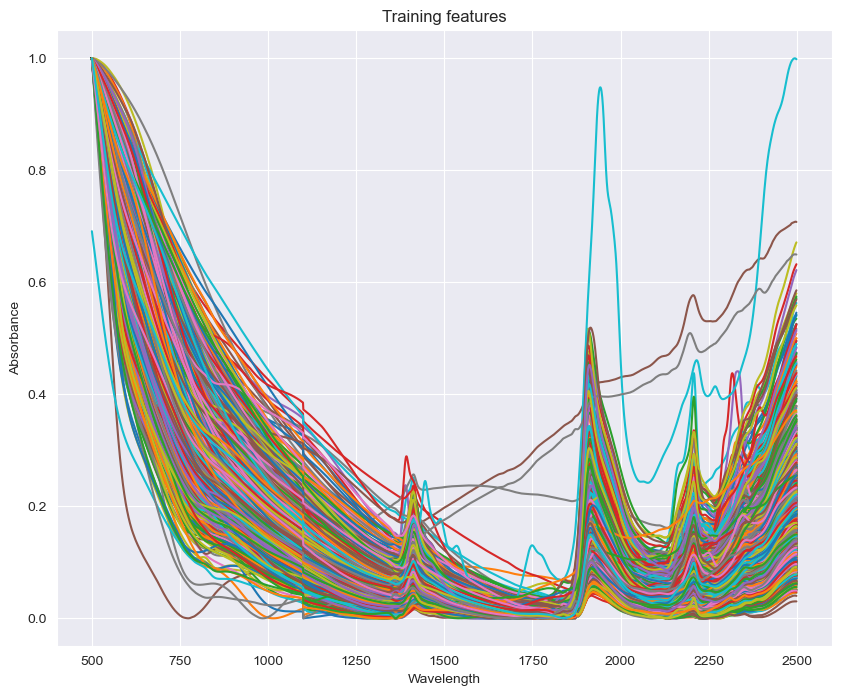

In [7]:
## Visualise features after transformation
for i in range(2000):
    x = np.arange(500, 2500)
    y = X_train[i]

    plt.plot(x, y)

plt.title("Training features")
plt.xlabel("Wavelength")
plt.ylabel("Absorbance")

plt.show()


In [8]:
## Sanitise target variables
# Replace erroneous values with a small value
train_mask = y_train <= 0
y_train_clean = y_train.copy()
y_train_clean[train_mask] = 1e-6
# Normalise target variables
y_train_log = np.log(y_train_clean)

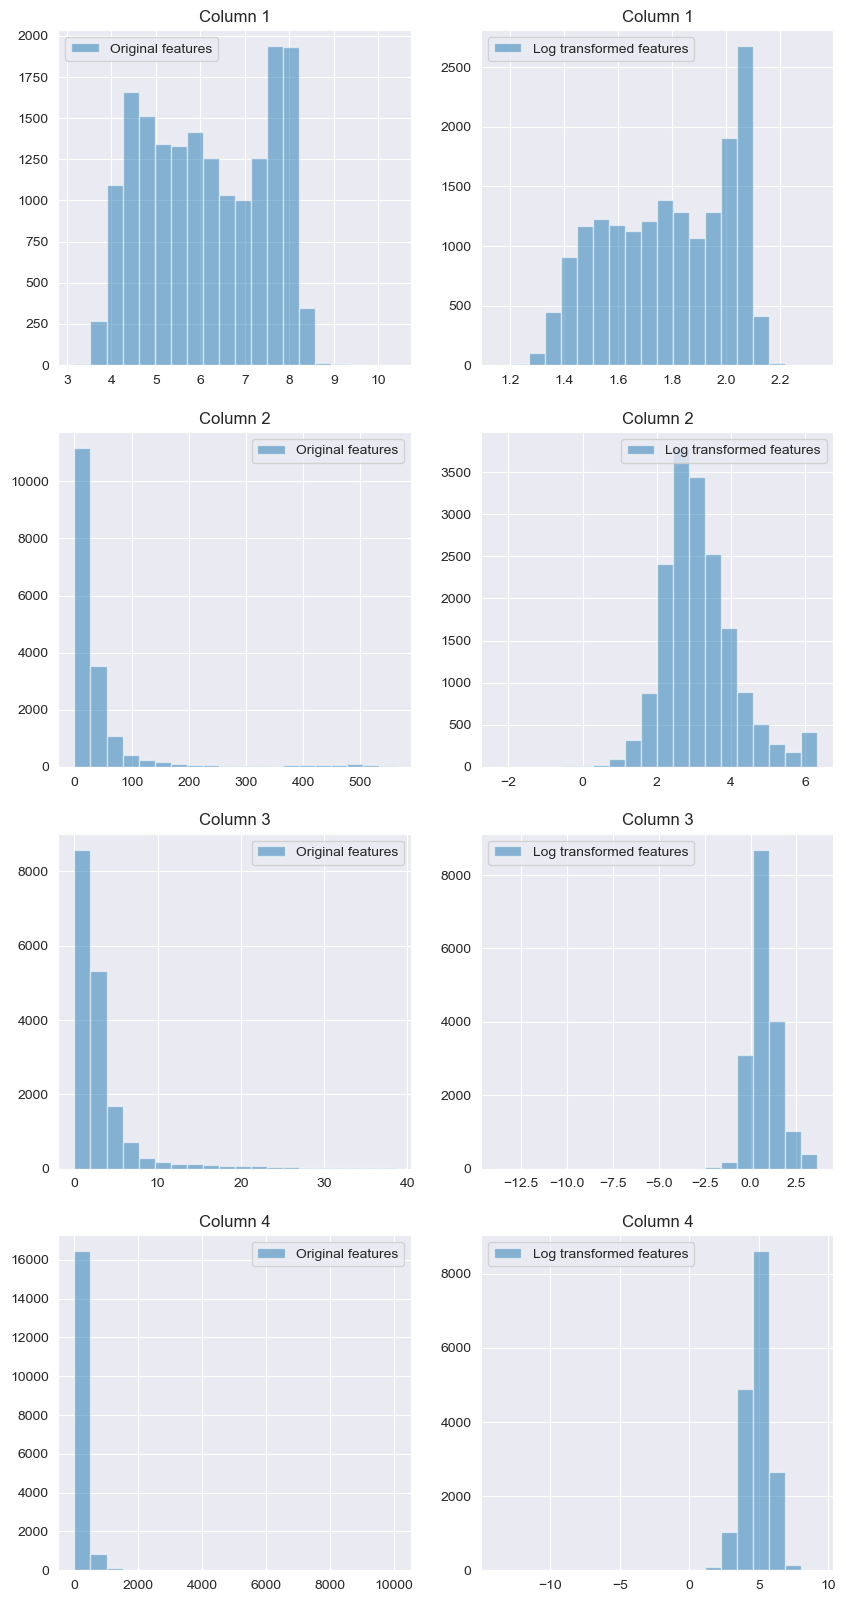

In [9]:
## Visualise transformed training target variables
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i in range(4):
    ax[i, 0].hist(y_train_clean[:, i], bins=20, alpha=0.5, label='Original features')
    ax[i, 1].hist(y_train_log[:, i], bins=20, alpha=0.5, label='Log transformed features')
    ax[i, 0].set_title(f'Column {i + 1}')
    ax[i, 1].set_title(f'Column {i + 1}')
    ax[i, 0].legend()
    ax[i, 1].legend()

plt.show()

In [10]:
## Apply normalisation to testing target variables
test_mask = y_test <= 0
y_test_clean = y_test.copy()
y_test_clean[test_mask] = 1e-6
y_test_log = np.log(y_test_clean)

### 2) Defining measure of success <a id="secondsection"></a>


A simple baseline measure of success was established to compare the performance of different models.  A commonly used baseline measure is the mean absolute error (MAE), which simply measures the average absolute difference between the predicted and actual values.  The MAE obtained from multiple linear regression was selected as the benchmark to beat.

The training dataset was used for this purpose, to ensure that data leakage is avoided at all costs.

In [18]:
## Fit multiple linear regression model to training features
mlr_pH = LinearRegression()
mlr_carbon = LinearRegression()
mlr_nitrogen = LinearRegression()
mlr_potassium = LinearRegression()

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = \
    train_test_split(X_train, y_train_log, train_size=0.6, random_state=42)

mlr_pH.fit(X_train_baseline, y_train_baseline[:, 0])
mlr_carbon.fit(X_train_baseline, y_train_baseline[:, 1])
mlr_nitrogen.fit(X_train_baseline, y_train_baseline[:, 2])
mlr_potassium.fit(X_train_baseline, y_train_baseline[:, 3])

pH_pred = mlr_pH.predict(X_test_baseline)
carbon_pred = mlr_carbon.predict(X_test_baseline)
nitrogen_pred = mlr_nitrogen.predict(X_test_baseline)
potassium_pred = mlr_potassium.predict(X_test_baseline)

mae_pH = mean_absolute_error(y_test_baseline[:, 0], pH_pred)
mae_carbon = mean_absolute_error(y_test_baseline[:, 1], carbon_pred)
mae_nitrogen = mean_absolute_error(y_test_baseline[:, 2], nitrogen_pred)
mae_potassium = mean_absolute_error(y_test_baseline[:, 3], potassium_pred)

print(f'''
pH MAE: {mae_pH}
Carbon MAE: {mae_carbon}
Nitrogen MAE: {mae_nitrogen}
Potassium MAE: {mae_potassium}
''')


pH MAE: 0.062971095804098
Carbon MAE: 0.3306341251923192
Nitrogen MAE: 0.2874953172417601
Potassium MAE: 0.501823620554427


The values above showcase the simple baseline measures to beat for the regression task at hand.

### 3) Evaluation protocol <a id="thirdsection"></a>


K-fold validation was selected as the evaluation protocol for the regression problem.  The dataset was neither significantly large nor small, thus neither holdout validation nor repeated cross validation would've been appropriate.  The dataset was too small for holdout validation to be appropriate, and variance of model performance would not be determinable.  On the contrary, repeated cross validation would've been to computationally demanding on a dataset for this size and the models used in the study.  A compromise was thus made, and K-fold validation was selected.  Specifically, 5-fold cross validation was settled on for this study.

For each fold, the training and validation losses were collected.  The losses for the respective validation folds were subsequently added together, and the average was taken across all folds.  The validation metrics (MAE) for each fold were collected and stored to be used for later analysis.  All values were kept in their transformed ranges, and values were not transformed back to their original scales.  The code below illustrates the functions that were used to evaluate model performance in this study.

In [ ]:
## Define function to run k-fold cross validated experiments
def cross_validate_model(variables, targets, models, cv=5, n_epochs=500, batch_size=512, verbose=0, learning_rate=1e-3, loss='mean_squared_error', seed=42):

    '''
    The cross_validate_model performs cross-validation for a set of models on a given dataset.
    The dataset takes in several parameters:

    :param variables: an array of input features.
    :param targets: an array of target variables.
    :param models: a list of model architectures to train and evaluate.
    :param cv: the number of cross-validation folds to use (default: 5).
    :param n_epochs: the number of training epochs for each model (default: 500).
    :param batch_size: the batch size for training (default: 512).
    :param verbose: whether to print training progress during training (default: 0).
    :param learning_rate: the learning rate for the optimizer (default: 1e-3).
    :param loss: the loss function to use for training (default: mean squared error).
    :param seed: the random seed to use for cross-validation splits (default: 42).
    :return: The function returns two pandas DataFrames: results_df and val_scores_df.
             The results_df DataFrame contains the training and validation loss for each model across all cross-validation folds.
             The val_scores_df DataFrame contains the validation error (mean absolute error) for each target variable for each cross-validation fold for each model.
    '''

    # Check if the number of input features and target variables are the same.
    if len(variables) == len(targets):

        # Create an empty dataframe to store the overall results for all models.
        results_df = pd.DataFrame(columns=['epoch', 'model', 'overall-train_loss', 'overall-val_loss',
                                           'pH-train_loss', 'pH-val_loss', 'carbon-train_loss', 'carbon-val_loss',
                                           'nitrogen-train_loss', 'nitrogen-val_loss', 'potassium-train_loss', 'potassium-val_loss'])

        # Create an empty dataframe to store the validation error for each fold of each model.
        val_scores_df = pd.DataFrame(columns=['model', 'fold', 'val_pH_error', 'val_carbon_error',
                                              'val_nitrogen_error', 'val_potassium_error'])

        # Iterate through each model architecture.
        for i, model in enumerate(models):

            print('\n\n')
            print('========================================')
            print(f'Processing model {i + 1} of {len(models)}')
            print('========================================')

            # Create an empty dataframe to store the validation results for each fold.
            fold_df = pd.DataFrame(columns=['epoch', 'model', 'overall-train_loss', 'overall-val_loss',
                                            'pH-train_loss', 'pH-val_loss', 'carbon-train_loss', 'carbon-val_loss',
                                            'nitrogen-train_loss', 'nitrogen-val_loss', 'potassium-train_loss', 'potassium-val_loss'])

            # Create folds
            k_folds = KFold(n_splits=cv, shuffle=True, random_state=seed)
            fold = 1 # Counter

            # Iterate through each fold.
            for train_index, val_index in k_folds.split(variables):

                print(f'Fold {fold} of {cv}')
                print('========================================')
                print('\n\n')

                # Split data into training and validation sets
                _X_train, _X_val = variables[train_index], variables[val_index]
                _y_train, _y_val = targets[train_index], targets[val_index]

                # Assign learning rate to optimiser
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                # Instantiate model
                _model = model(num_features=variables.shape[1])
                # Compile model with relevant settings
                _model.compile(loss=loss, optimizer=optimizer, metrics=['mean_absolute_error'])
                # Fit model and collect training history
                history = _model.fit(_X_train,
                                     [_y_train[:, 0], _y_train[:, 1], _y_train[:, 2], _y_train[:, 3]],
                                     validation_data=(_X_val, [_y_val[:, 0], _y_val[:, 1], _y_val[:, 2], _y_val[:, 3]]),
                                     epochs=n_epochs, batch_size=batch_size,
                                     verbose=verbose)
                # Collect validation loss and validation error metrics
                validation_loss, pH_loss, carbon_loss, nitrogen_loss, potassium_loss, \
                    pH_mae, carbon_mae, nitrogen_mae, potassium_mae = _model.evaluate(_X_val,
                                                                                      [_y_val[:, 0], _y_val[:, 1], _y_val[:, 2], _y_val[:, 3]],
                                                                                      batch_size=batch_size)
                # Create dataframe with validation results from current fold
                validation_df = pd.DataFrame.from_dict({'epoch': np.arange(1, n_epochs+1),
                                                        'model': np.repeat(i + 1, n_epochs),
                                                        'overall-train_loss': history.history['loss'],
                                                        'overall-val_loss': history.history['val_loss'],
                                                        'pH-train_loss': history.history['pH_loss'],
                                                        'pH-val_loss': history.history['val_pH_loss'],
                                                        'carbon-train_loss': history.history['carbon_loss'],
                                                        'carbon-val_loss': history.history['val_carbon_loss'],
                                                        'nitrogen-train_loss': history.history['nitrogen_loss'],
                                                        'nitrogen-val_loss': history.history['val_nitrogen_loss'],
                                                        'potassium-train_loss': history.history['potassium_loss'],
                                                        'potassium-val_loss': history.history['val_potassium_loss']
                                                        })
                # Create dataframe with validation error metrics for current fold
                val_scores = pd.DataFrame.from_dict({'model': f'Model {i + 1}',
                                                     'fold': [fold],
                                                     'val_pH_error': [pH_mae],
                                                     'val_carbon_error': [carbon_mae],
                                                     'val_nitrogen_error': [nitrogen_mae],
                                                     'val_potassium_error': [potassium_mae]
                                                     })
                # Check if dataframe already exists,
                # If true, add current validation loss to existing values;
                # if not, concatenate this fold's validation loss to empty dataframe
                if fold_df.shape[0] != 0:
                    fold_df['overall-train_loss'] += validation_df['overall-train_loss']
                    fold_df['overall-val_loss'] += validation_df['overall-val_loss']
                    fold_df['pH-train_loss'] += validation_df['pH-train_loss']
                    fold_df['pH-val_loss'] += validation_df['pH-val_loss']
                    fold_df['carbon-train_loss'] += validation_df['carbon-train_loss']
                    fold_df['carbon-val_loss'] += validation_df['carbon-val_loss']
                    fold_df['nitrogen-train_loss'] += validation_df['nitrogen-train_loss']
                    fold_df['nitrogen-val_loss'] += validation_df['nitrogen-val_loss']
                    fold_df['potassium-train_loss'] += validation_df['potassium-train_loss']
                    fold_df['potassium-val_loss'] += validation_df['potassium-val_loss']
                else:
                    fold_df = pd.concat([fold_df, validation_df])
                # Concatenate current fold's validation error metrics to dataframe
                val_scores_df = pd.concat([val_scores_df, val_scores])
                # Increment counter
                fold += 1
            # Obtain average training and validation losses across all folds
            fold_df['overall-train_loss'] = validation_df['overall-train_loss'].divide(cv)
            fold_df['overall-val_loss'] = validation_df['overall-val_loss'].divide(cv)
            fold_df['pH-train_loss'] = validation_df['pH-train_loss'].divide(cv)
            fold_df['pH-val_loss'] = validation_df['pH-val_loss'].divide(cv)
            fold_df['carbon-train_loss'] = validation_df['carbon-train_loss'].divide(cv)
            fold_df['carbon-val_loss'] = validation_df['carbon-val_loss'].divide(cv)
            fold_df['nitrogen-train_loss'] = validation_df['nitrogen-train_loss'].divide(cv)
            fold_df['nitrogen-val_loss'] = validation_df['nitrogen-val_loss'].divide(cv)
            fold_df['potassium-train_loss'] = validation_df['potassium-train_loss'].divide(cv)
            fold_df['potassium-val_loss'] = validation_df['potassium-val_loss'].divide(cv)

            results_df = pd.concat([results_df, fold_df])
        # Return result dataframes
        return results_df, val_scores_df
    else:
        print('Feature and target length not equal.')

In [38]:
## Define function to ru
def summarise_validation_results(input_df, model_names=None):

    print('Model validation results across all folds:\n')
    x = (validation_scores.groupby('model')
         .aggregate({'val_pH_error': ['mean', 'std'],
                     'val_carbon_error': ['mean', 'std'],
                     'val_nitrogen_error': ['mean', 'std'],
                     'val_potassium_error': ['mean', 'std']}))

    x = x.reset_index()
    new_col_names = []
    for col_name in x.columns:
        if col_name[1] != '':
            clean_name = col_name[0][4:-6]
            new_col_names.append(' '.join(('log_' + clean_name, col_name[1])))
        else:
            new_col_names.append(col_name[0])

    x.columns = new_col_names
    if model_names:
        x['model'] = x['model'].replace(model_names)

    print(x.to_string(max_colwidth=20), "\n\n\n")

    val_scaler = MinMaxScaler()
    numeric_colums = input_df.select_dtypes(include=['int64', 'float64']).columns
    x_scaled = input_df.copy()
    x_scaled[numeric_colums] = val_scaler.fit_transform(x_scaled[numeric_colums])

    column_names = x_scaled.columns.tolist()
    for i, name in enumerate(column_names[2:]):
        column_names[i+2] = name[4:-6]
    x_scaled.columns = column_names
    x_scaled_long = x_scaled.melt(id_vars=['model'],
                                  value_vars=['pH', 'carbon', 'nitrogen', 'potassium'],
                                  var_name='variable', value_name='error')

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
    for i, model in enumerate(x_scaled_long['model'].unique()):
        sns.boxplot(x='variable', y='error', data=x_scaled_long[x_scaled_long['model'] == model], ax=axes[i])

    fig.subplots_adjust(top=0.95)
    fig.suptitle('Cross validation results for each variable')
    plt.setp(axes[:], xlabel='Target Variables', ylabel='Scaled Validation Mean Absolute Error')
    plt.show()

In [23]:
def visualise_experimental_results(input_df, title='Some title', model_names=None):

    target_df = input_df.melt(id_vars=['epoch', 'model'],
                              value_vars=['overall-train_loss', 'overall-val_loss',
                                          'pH-train_loss', 'pH-val_loss', 'carbon-train_loss', 'carbon-val_loss',
                                          'nitrogen-train_loss', 'nitrogen-val_loss', 'potassium-train_loss', 'potassium-val_loss'],
                              var_name='intermediate', value_name='values')

    split_cols = target_df['intermediate'].str.split('-', expand=True)
    split_cols.columns = ['variable', 'loss_type']
    target_df = pd.concat([target_df, split_cols], axis=1)
    target_df = target_df.drop(['intermediate'], axis=1)
    target_df_wide = target_df.pivot(index=['model', 'variable', 'epoch'],
                                     columns='loss_type',
                                     values='values').reset_index()

    sort_order = ['overall', 'pH', 'carbon', 'nitrogen', 'potassium']
    target_df_wide['variable'] = pd.Categorical(target_df_wide['variable'],
                                                categories=sort_order,
                                                ordered=True)

    target_df_wide.sort_values('variable')

    if model_names:
        target_df_wide['model'] = target_df_wide['model'].replace(model_names)

    g = sns.FacetGrid(target_df_wide, col='model', row='variable', sharey=False, margin_titles=True)
    g.map(plt.plot, 'epoch', 'train_loss', color='red', linestyle='dashed', label='Training', alpha=0.8)
    g.map(plt.plot, 'epoch', 'val_loss', color='yellow', label='Validation', alpha=0.5)
    g.set_axis_labels('Epoch', 'Loss')
    g.add_legend(title='Loss')
    sns.set(rc={"figure.figsize":(8, 4)})

    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

### 4) Model architecture engineering <a id="fifthsection"></a>


Three model architectures were developed for use in this study.  Each of the model architecture leveraged convolutional layers in the architecture.  The first model architecture, denseSpectraNet, relied on convolutional layers to extract meaningful features from the dataset and reduce the dimensionality.  The output was then fed to fully connected layers and fed to four final output layers.

The second architecture, vggSpectraNet, was modelled on the neural network model proposed by Simonyan & Zisserman (2015).  It is one of the more famous architectures to have been developed in the field.  The output of the convolutional layers was then fed to fully connected layers and similarly fed to four final output layers.

The third architecture, reSpectraNet, was modelled on the neural network model proposed by He, et al. (2016).  This is another very famous model architecture, and relies on residual skip connects that overcomes the vanishing gradient problem often encountered in deep learning.  A more detailed description of each model is laid out below.

### a) DenseSpectraNet: <a id="densespectranet"></a>

The model architecture consisted of a series of initial convolutional layers, intermittently followed by max-pooling layers which reduced the spatial dimensionality of the input tensor.  Simultaneously, the channel dimensionality was increased by increasing the number of filters.  The convolutional layers used the relu activation function, and the max-pooling layers used a pool size of 2 with stride 2.  The number of filters in each convolutional layer was incrementally increased from 2 to 32.  These initial convolutional layers were designed to learn features from the input data that are relevant for predicting the target variables.

The output of the convolutional layers was flattened into a one-dimensional vector, which was in turn pass through a series of fully connected layers with varying numbers of hidden units.  Each fully connected layer used the relu activation function.  The purpose of these layers were to further process the learned features and transform them into richer representations for the final output layers.

Finally, the intermediate fully connected layers were followed by four output layers, one for each of the four target variables.  Each output layer consisted of a dense layer with 16 hidden units and a linear activation function.

A visualisation of the network architecture is shown below:

<img src="assets/denseSpectraNet.png" alt="DenseSpectraNet Model Architecture" />

In [ ]:
def denseSpectraNet(num_features):
    input_tensor = Input(shape=(num_features, 1))

    x = Conv1D(2, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Conv1D(4, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Conv1D(8, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Flatten()(x)

    x = Dense(512, activation='relu')(x)
    x = Dense(1028, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    pH_features = Dense(16, activation='relu')(x)
    pH_output = Dense(1, activation='linear', name='pH')(pH_features)

    OC_features = Dense(16, activation='relu')(x)
    OC_output = Dense(1, activation='linear', name='carbon')(OC_features)

    N_features = Dense(16, activation='relu')(x)
    N_output = Dense(1, activation='linear', name='nitrogen')(N_features)

    K_features = Dense(16, activation='relu')(x)
    K_output = Dense(1, activation='linear', name='potassium')(K_features)

    _model = tf.keras.Model(inputs=input_tensor, outputs=[pH_output, OC_output, N_output, K_output])
    return _model

### b) VGGSpectraNet: <a id="vggspectranet"><a/>


The model architecture is based on the VGG network, which is primarily known for its use of multiple convolutional and max-pooling layers.  The model consisted of six convolutional blocks, each containing multiple convolutional layers.  The number of filters was sequentially increased for each block.  Each convolutional block was followed by a max pooling layer that served to reduce the spatial dimensionality of the previous output feature maps.  The outputs of the last convolutional block was flattened and fed into two fully connected layers that used the relu activation function.  These layers were intended to extract high-level features from the convolutional layer output, and produced a 32 dimensional feature vector.

The final feature vector was then passed through four seperate sets of two fully connected layers that used relu activation functions, one set for each output prediction.  Each fully connected set was intended to produce a 16-dimensional feature vector specific to the corresponding output, which was then passed through a single dense layer with a linear activation function to produce the scalar prediction of interest.

A visualisation of the network is shown below:


<img src="assets/vggSpectra.png" alt="VGGSpectraNet model architecture" />

In [ ]:
def vggSpectraNet(num_features):
    # Create input tensor
    input_tensor = Input(shape=(num_features, 1))

    # Convolutional block 1
    x = Conv1D(4, kernel_size=7, padding='same', activation='relu')(input_tensor)
    x = Conv1D(4, kernel_size=7, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    # Convolutional block 2
    x = Conv1D(8, kernel_size=5, padding='same', activation='relu')(x)
    x = Conv1D(8, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    # Convolutional block 3
    x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    # Convolutional block 4
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    # Convolutional block 5
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    # Convolutional block 6
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    # Flatten previous convolutional block's output and feed to fully connected layer
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # Define output layer
    pH_features = Dense(16, activation='relu')(x)
    pH_output = Dense(1, activation='linear', name='pH')(pH_features)

    OC_features = Dense(16, activation='relu')(x)
    OC_output = Dense(1, activation='linear', name='carbon')(OC_features)

    N_features = Dense(16, activation='relu')(x)
    N_output = Dense(1, activation='linear', name='nitrogen')(N_features)

    K_features = Dense(16, activation='relu')(x)
    K_output = Dense(1, activation='linear', name='potassium')(K_features)

    # Compose and return final model
    _model = tf.keras.Model(inputs=input_tensor, outputs=[pH_output, OC_output, N_output, K_output])

    return _model

### c) ReSpectraNet: <a id="respectranet"><a/>


The model architecture was based on the RESNET-16 model architecture, and consisted of several convolutional and residual blocks that were followed by a dense layer to produce the target outputs.  A residual block function was created to be used in the architecture.  It worked by taking an input tensor, which was saved as a residual, and two convolutional layers with a specified number of filters and kernel size.  These were applied to the imput tensor, after which max-pooling was applied if the pooling flag was set to true.  The residual tensor was also passed through a 1D convolutional layer with the same number of filters and kernel size, to match the dimensions of each convolutional section.  The output and residual tensors were added, and the corresponding tensor was returned as input to the next block.

The architecture of the model took an input tensor and passed it through two convolutional layers.  These layers were followed by multiple residual blocks of convolutional layers.  The network ended with a dense layer consisting of two hidden layers with 128 and 64 units respectively.  The output feature vector was then followed by four dense layers corresponding to each target variable.  These dense layers were finally followed by an output layer that generated the predicted value for each target variable.

A visualisation of the model architecture is shown below:


<img src="assets/reSpectraNet.png" alt="ReSpectraNet model architecture" />

In [41]:
def residualBlock(x, num_filters, kernel_size, pooling=True):
    residual = x
    x = Conv1D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = Conv1D(num_filters, kernel_size=kernel_size, padding='same')(x)
    if pooling:
        x = MaxPooling1D(pool_size=2, padding='same')(x)
        residual = Conv1D(num_filters, 1, strides=2)(residual)
    elif num_filters != residual.shape[-1]:
        residual = Conv1D(num_filters, 1)(residual)
    x = keras.layers.add([x, residual])
    return x

def reSpectraNet(num_features):
    # Create input tensor
    input_tensor = Input(shape=(num_features, 1))

    # Initial convolutional layer
    x = Conv1D(4, kernel_size=7, padding='same', activation='relu')(input_tensor)
    x = Conv1D(4, kernel_size=7, padding='same', activation='relu')(x)

    # Residual blocks
    x = residualBlock(x, num_filters=16, kernel_size=3)
    x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)

    x = residualBlock(x, num_filters=32, kernel_size=3)
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)

    x = residualBlock(x, num_filters=64, kernel_size=3)
    x = residualBlock(x, num_filters=64, kernel_size=3)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)

    x = residualBlock(x, num_filters=128, kernel_size=3)
    x = residualBlock(x, num_filters=128, kernel_size=3, pooling=False)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Final dense layer
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Define output layer
    pH_features = Dense(16, activation='relu')(x)
    pH_output = Dense(1, activation='linear', name='pH')(pH_features)

    OC_features = Dense(16, activation='relu')(x)
    OC_output = Dense(1, activation='linear', name='carbon')(OC_features)

    N_features = Dense(16, activation='relu')(x)
    N_output = Dense(1, activation='linear', name='nitrogen')(N_features)

    K_features = Dense(16, activation='relu')(x)
    K_output = Dense(1, activation='linear', name='potassium')(K_features)

    # Compose and return final model
    _model = tf.keras.Model(inputs=input_tensor, outputs=[pH_output, OC_output, N_output, K_output])

    return _model

### 5) Model selection <a id="sixthsection"></a>


Each model was defined and trained and evaluated on the training data.  After training was completed, the results were analysed and interpreted.  To accurately evaluate model performance, 5-fold cross validation was employed.

In [ ]:
## Define models
vggModel = vggSpectraNet
resModel = reSpectraNet
denseModel = denseSpectraNet
models = [denseModel, vggModel, resModel]

# Run modelling experiment
training_results, validation_scores = cross_validate_model(variables=X_train, targets=y_train_log, models=models, loss='huber_loss',
                                                           cv=5, n_epochs=500, batch_size=2048, learning_rate=1e-4, verbose=1)

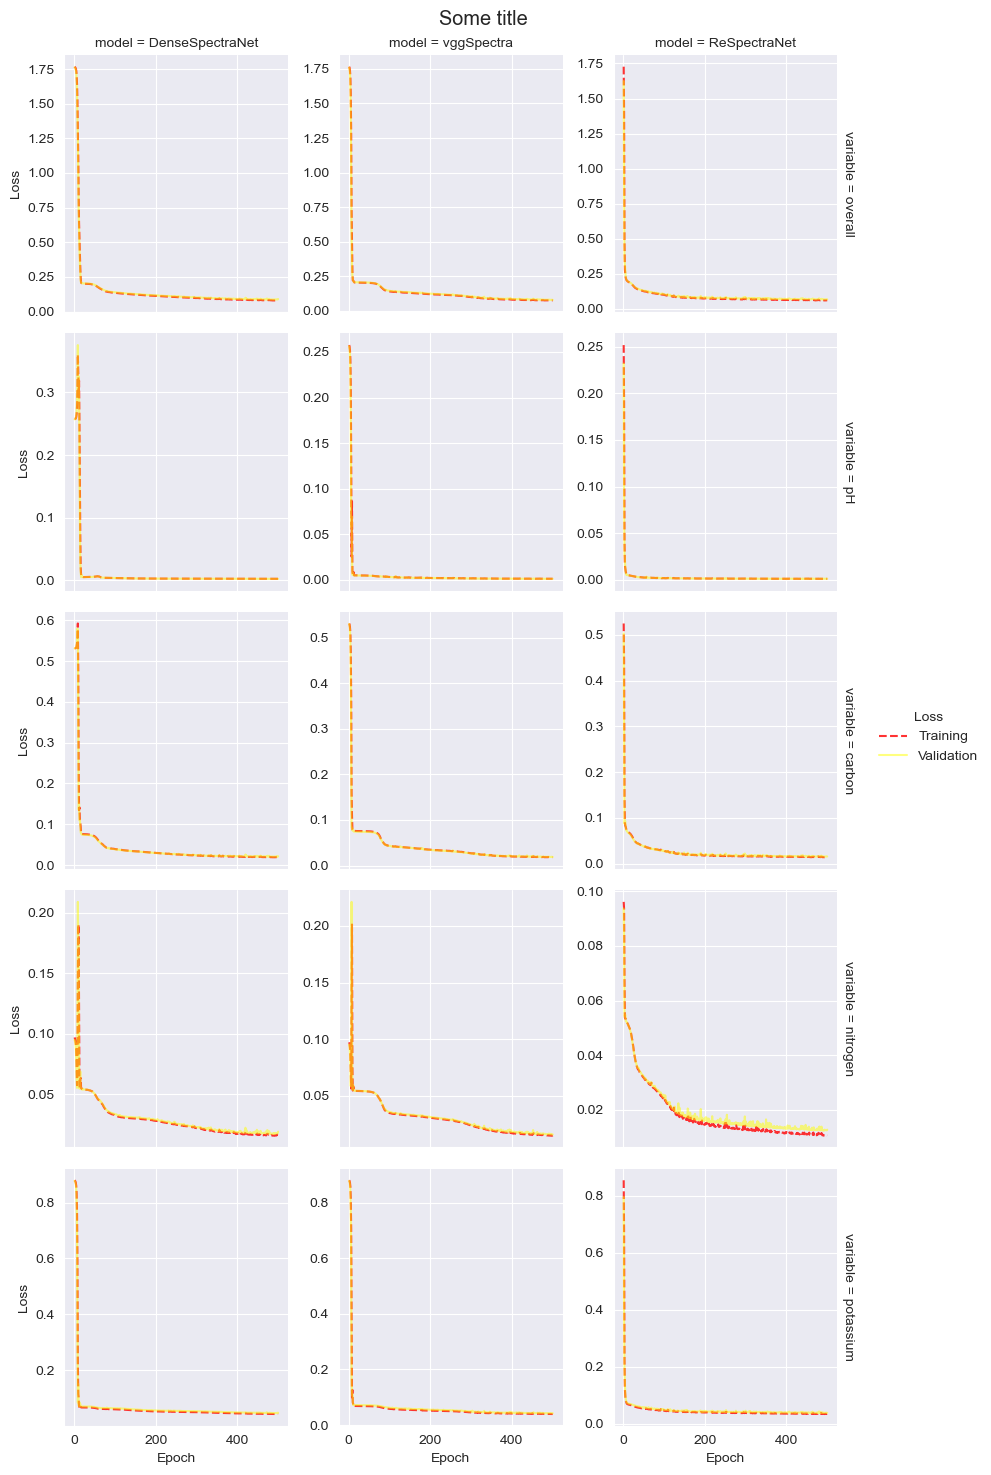

In [24]:
## Visualise experimental results
visualise_experimental_results(input_df=training_results, model_names={1: 'DenseSpectraNet', 2: 'vggSpectra', 3: 'ReSpectraNet'})

The validation result notably showed that not one of the models were able to overfit on the training datasets.  The ReSpectraNet model showed slight signs on overfitting on the nitrogen variable.  All models reached a notably low general loss around 100 epochs.

The training and validation losses were similar for all models regarding the pH variable.  The ReSpectraNet model converged earlier on the carbon variable compared to the other models, however there was only a slight difference.  All models showed noisy loss values for the nitrogen variable, which may indicate that this is the more challenging variable to model for.  Lastly, all models performed similarly on the potassium variable.

Model validation results across all folds:

             model  log_pH mean  log_pH std  log_carbon mean  log_carbon std  log_nitrogen mean  log_nitrogen std  log_potassium mean  log_potassium std
0  DenseSpectraNet     0.131908    0.037691         0.422626        0.166804           0.379717          0.116506            0.575613           0.069344
1       vggSpectra     0.090959    0.003001         0.324100        0.006941           0.291049          0.011940            0.506235           0.007806
2     ReSpectraNet     0.087997    0.003276         0.292979        0.007114           0.260858          0.010903            0.481172           0.008725 



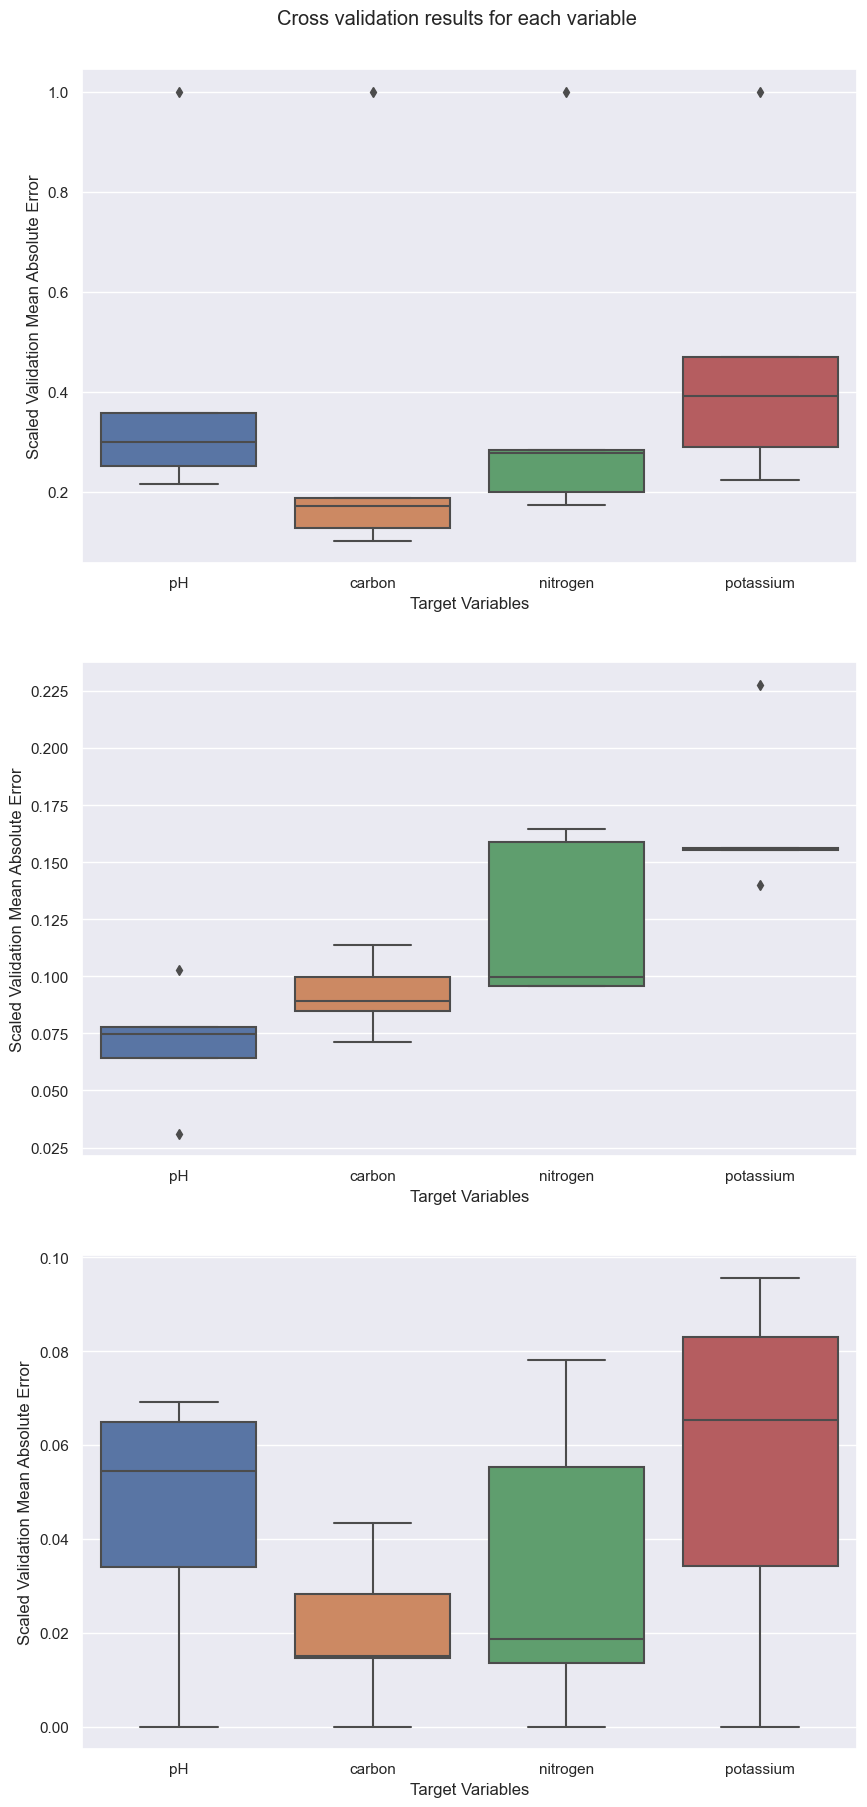

In [39]:
summarise_validation_results(input_df=validation_scores, model_names={'Model 1': 'DenseSpectraNet', 'Model 2': 'vggSpectra', 'Model 3': 'ReSpectraNet'})

Out of all the models, the ReSpectraNet model came out on top.  It scored significantly better on all target variables.  Interestingly, none of the models were able to beat the baseline metric for pH, with all models showing weaker performance than multiple linear regression.  The DenseSpectraNet model was not able to beat any of the baseline metrics, and thus performed worse than multiple linear regression.

The DenseSpectraNet was the weakest model, as stated above.  It's performance was generally more erratic, as can be seen from the validation summary above.  The model showed to be able to predict carbon most accurately in comparison to the other target variables.  The model showed the weakest performance on potassium prediction.  It is clear that this model architecture was not well suited for this modelling task given its current set of hyperparameters.  The reason for the weak performance may be attributable to information loss in the convolutional layers, and that the fully connected layers were not set up properly to be able to formulate meaningful representations of the data.

The vggSpectraNet model performed second best out of all models, and was able to only slightly beat the baseline metrics, except pH.  The model's performance was also the most erratic out of all the other models.  In contrast to the other models, this model was able to predict pH most accurately in comparison to the other target variables.  The model struggled most to predict potassium, and was on par with the baseline metric established through multiple linear regression.  The models average performance may be attributed to the network being quite deep, and that vanishing gradients may have hampered the models ability to converge properly.

Finally, the ReSpectraNet model clearly performed best out of all the models.  The model was able to comfortably beat the established baseline metrics, in all but pH.  It was also shown to be the most stable model out of the three, and yielded similar error metrics across all validation folds.  The model was most able on predicting carbon, and performed the worst on predicting potassium.  The models better performance may be attributed to the residual blocks and skip connections, that would allow the model to overcome the limitations experienced by vggSpectraNet.  With proper fine-tuning of the hyperparameters, the ReSpectraNet model may show to be a satisfactory model to predict selected soil properties from soil spectral data.

## Final model evaluation <a id="finalmodel"></a>



The ReSpectraNet model architecture was selected as the final model for this study, and was evaluated on the testing set.  All hyperparameters remained unchanged for the final evaluation.  The final model was trained on all training data and then evaluated on the test dataset.

In [ ]:
final_model = reSpectraNet(num_features=X_train.shape[1])

final_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
final_model.compile(loss='huber_loss', optimizer=final_optimizer, metrics=['mean_absolute_error'])

training_history = final_model.fit(X_train, y_train_log, epochs=100, batch_size=2048)
test_loss, pH_loss, carbon_loss, nitrogen_loss, potassium_loss,\
    pH_mae, carbon_mae, nitrogen_mae, potassium_mae = final_model.evaluate(X_test, y_test_log)

In [45]:
print(f"""
Test loss for final model: {round(test_loss, 2)}
Test MAE for variables:
pH:        {round(pH_mae, 2)}
Carbon:    {round(carbon_mae, 2)}
Nitrogen:  {round(nitrogen_mae, 2)}
Potassium: {round(potassium_mae, 2)}""")


Test loss for final model: 3.86
Test MAE for variables:
pH:        1.4
Carbon:    1.4
Nitrogen:  1.4
Potassium: 1.4


The model validation on the test set was significantly worse than was seen during training.  The reason for this is that the model was not trained for long enough, and it seemed to have gotten stuck in a local minima, which resulted in the model not being able to properly converge.  Unfortunately, I ran out of time with this project and could not complete a longer training run.


## Conclusion <a id="conclusion"></a>


In conclusion, the study evaluated three convolutional neural network architectures with the goal of predicting soil pH and carbon, nitrogen, and potassium contents from soil spectroscopy data.  The results of this study indicate that the model based on RESNET-16 performed the best, outperforming the other two model architectures and achieving better performance than the multiple linear regression baseline for all target variables, except for soil pH.

Despite the promising results, the study had several limitations.  The first is that the study only utilised a single dataset for model evaluation, which may limit the generalisability of the study's findings.  Additionally, the study only considered a limited number of convolutional neural network architectures, and it might be possible that other architectures could achieve better results.  Lastly, the study did not explore the impact of hyperparameters on model performance in depth, as there may be better combinations of hyperparameters that were not considered in this study.

The study can be improved on in a few areas, and it is recommended that additional neural network architectures be explored and that a more comprehensive hyperparameter search be conducted.  Additionally, future studies could also include multiple datasets to evaluate the generalisability of the models.  Finally, given that none of the models were able to beat the baseline metrics for soil pH, future studies should investigate more suitable approaches for modelling or feature engineering techniques tht may  be more effective at predicting this variable.

In summary, the study demonstrated the potential of convolutional neural networks for predicting multiple soil properties from soil spectroscopy data, but more research is needed to optimise model performance and overcome the limitations highlighted in this study.

## References <a id="references"></a>


Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., Corrado, G.S., Davis, A., Dean, J., Devin, M., Ghemawat, S., Goodfellow, I., Harp, A., Irving, G., Isard, M., Jozefowicz, R., Jia, Y.,
Kaiser, L., Kudlur, M., Levenberg, J., Mané, D., Schuster, M., Monga, R., Moore, S., Murray, D., Olah, C., Shlens, J., Steiner, B., Sutskever, I., Talwar, K., Tucker, P., Vanhoucke, V., Vasudevan, V., Viégas, F., Vinyals, O., Warden, P., Wattenberg, M., Wicke, M., Yu, Y., and Zheng, X. TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org.

Grunwald, S., Thompson, J. & Boettinger, J., 2011. Digital Soil Mapping and Modeling at Continental Scales: Finding Solutions for Global Issues. Soil Science Society of America Journal, Volume 75, pp. 1201-1213.

He, K., Zhang, X., Ren, S., Sun, J., 2016. Deep residual learning for image recognition. IEEE Conferrence on Computer Vision and Pattern Recognition (CVPR). DOI: 10.1109/CVPR.2016.90

Lei, T. & Sun, D. W., 2022. Achieving joint calibration of soil Vis-NIR spectra across instruments, soil types and properties by an attention-based spectra encoding-spectra/property decoding architecture. Geoderma, Volume 405, doi:10.1016/j.geoderma.2021.115449.

Nocita, M. et al., 2015. Soil Spectroscopy: An Alternative to Wet Chemistry for Soil Monitoring. Advances in Agronomy, Volume 132, doi:10.1016/bs.agron.2015.02.002.

Orgiazzi, A., Ballabio, C., Panagos, P., Jones, A., Fernández-Ugalde, O. 2018. LUCAS Soil, the largest expandable soil dataset for Europe: A review. European Journal of Soil Science, 69(1): 140-153, DOI: 10.1111/ejss.12499

Padarian, J., Minasny, B. & McBratney, A. B., 2019. Using deep learning to predict soil properties from regional spectral data. Geoderma Regional, Volume 16, doi:10.1016/j.geodrs.2018.e00198.

Ramirez-Lopez, L. et al., 2013. The spectrum-based learner: A new local approach for modeling soil vis-NIR spectra of complex datasets. Geoderma, Volume 195-196, pp. 268-279.

Ren, J., Zhao, Y. & Yu, K., 2022. LIBS in agriculture: A review focusing on revealing nutritional and toxic elements in soil, water, and crops. Computers and Electronics in Agriculture, Volume 197, doi:10.1016/j.compag.2022.106986.

Simonyan, K., Zisserman, A., 2015. Very deep convolutional networks for large-scale image recognition. ICLR conference - 2015. DOI: NA

Viscarra Rossel, R. A. & McBratney, A. B., 1998. Soil chemical analytical accuracy and costs: implications from Precision Agriculture. Australian Journal of Experimental Agriculture, Volume 38, pp. 765 - 775.

Xu, S., Zhao, Y., Wang, M. & Shi, X., 2018. Comparison of multivariate methods for estimating selected soil properties from intact soil cores of paddy fields by Vis-NIR spectroscopy. Geoderma, Volume 310, pp. 29-43.

van Leeuwen, C. C. E., Mulder, V. L., Batjes, N. H. & Heuvelink, G. B. M., 2022. Statistical modelling of measurement error in wet chemistry soil data. European Journal of Soil Science, 73(1), doi:10.1111/ejss.13137.